In [18]:
import re
import os
import io
import sys

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.spatial import distance

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import scipy.io as sio

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### Load Trade barriers definitions

In [3]:
Tariff_def, Nontarrif_def = {}, {}

Files = []
basepath = 'C:/Users/user/Desktop/Trade barrier/Barriers definition/Tariff/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        Files.append(entry[:-4])
        Tariff_def[entry[:-4]] = {'Text':[], 'Vec':[]}
        
print(Files)        
for File in Files:
    with open(basepath+File+'.txt') as f:
         Tariff_def[File]['Text'] = f.read().splitlines()


Files = []
basepath = 'C:/Users/user/Desktop/Trade barrier/Barriers definition/NonTariff/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        Files.append(entry[:-4])
        Nontarrif_def[entry[:-4]] = {'Text':[], 'Vec':[]}

print(Files)        
for File in Files:
    with open(basepath+File+'.txt') as f:
         Nontarrif_def[File]['Text'] = f.read().splitlines()

['Direction', 'Distribution points', 'Import restraints', 'Purpose', 'Rates', 'Time length']
['Customs and entry procedures', 'Financial control', 'Government participation in trade', 'Product requirements', 'Quotas']


In [4]:
with open('Finnish_Sentiments.pkl','rb') as pickle_in:
     Texts_Sentiments = pickle.load(pickle_in)

Texts = Texts_Sentiments['Negative']

In [5]:
len(Texts)

690

139

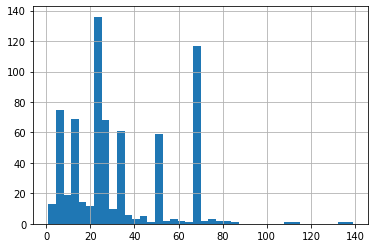

In [6]:
seq_len = [len(i.split()) for i in Texts]

pd.Series(seq_len).hist(bins = 40)
max(seq_len)

In [8]:
# specify GPU device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1070'

In [9]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: GeForce GTX 1070


In [8]:
def remove_stopwords(texts):
    return [' '.join([word for word in doc.lower().split() if word not in stopwords.words('english')]) for doc in texts]

### Import BERT Model and BERT Tokenizer

In [9]:
def Bert_Features(Data, max_seq_len, batch_size = 16):
    device = torch.device("cuda")
    
    # import BERT-base pretrained model
    bert = AutoModel.from_pretrained('bert-base-uncased')
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    bert = bert.to(device)

    Tokens_Data = tokenizer.batch_encode_plus(Data, max_length = max_seq_len,
             padding=True, truncation=True,return_token_type_ids=False)

    Data_seq = torch.tensor(Tokens_Data['input_ids']).to(device)
    Data_mask = torch.tensor(Tokens_Data['attention_mask']).to(device)

    train_data = TensorDataset(Data_seq, Data_mask)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler,\
                              batch_size=batch_size)
    Features = []

    for step, batch in enumerate(train_dataloader):   
        batch = [r.to(device) for r in batch]
        sent_id, mask = batch
        _, Feature_Vec = bert(sent_id, mask)

        Feature_Vec = Feature_Vec.detach().cpu().numpy()        
        Features.append(Feature_Vec)
    
    Features  = np.concatenate(Features, axis=0)
    return Features

In [10]:
torch.cuda.empty_cache()

batch_size = 16
max_seq_len = 140
Texts = remove_stopwords(Texts)
Features = Bert_Features(Texts, max_seq_len)

torch.cuda.empty_cache()

In [11]:
Features.shape

(690, 768)

In [12]:
for barrier in Tariff_def.keys():
    Tariff_def[barrier]['Vec'] = Bert_Features(remove_stopwords(Tariff_def[barrier]['Text']), max_seq_len)

for barrier in Nontarrif_def.keys():
    Nontarrif_def[barrier]['Vec'] = Bert_Features(remove_stopwords(Nontarrif_def[barrier]['Text']), max_seq_len)

In [13]:
#https://danushka.net/lect/dm/Numpy-basics.html
Similarities = []
for Feature in Features:
    scores = []
    for barrier in Tariff_def.keys():
        MaxSim ,Sim = 0, 0
        for Vec in Tariff_def[barrier]['Vec']:
            Sim = round(1-distance.cosine(Feature, Vec), 2)
            if MaxSim < Sim:
                MaxSim = Sim
        scores.append(MaxSim)
        
    for barrier in Nontarrif_def.keys():
        MaxSim ,Sim = 0, 0
        for Vec in Nontarrif_def[barrier]['Vec']:
            Sim = round(1-distance.cosine(Feature, Vec), 2)
            if MaxSim < Sim:
                MaxSim = Sim
        scores.append(MaxSim)
    Similarities.append(scores)

In [14]:
Similarities[0:10],Texts[2]

([[0.57, 0.63, 0.59, 0.59, 0.67, 0.67, 0.58, 0.5, 0.81, 0.51, 0.47],
  [0.98, 0.99, 0.98, 0.99, 0.98, 0.97, 0.96, 0.97, 0.97, 0.97, 0.94],
  [0.97, 0.98, 0.97, 0.96, 0.97, 0.98, 0.98, 0.98, 0.97, 0.98, 0.97],
  [0.98, 0.99, 0.99, 0.99, 0.97, 0.98, 0.96, 0.97, 0.97, 0.97, 0.95],
  [0.96, 0.98, 0.98, 0.97, 0.97, 0.98, 0.95, 0.97, 0.97, 0.95, 0.94],
  [0.96, 0.98, 0.98, 0.97, 0.97, 0.98, 0.95, 0.97, 0.97, 0.96, 0.95],
  [0.96, 0.96, 0.97, 0.95, 0.98, 0.97, 0.97, 0.96, 0.97, 0.97, 0.97],
  [0.97, 0.98, 0.97, 0.98, 0.98, 0.97, 0.96, 0.95, 0.96, 0.96, 0.94],
  [0.98, 0.99, 0.99, 0.99, 0.97, 0.98, 0.96, 0.97, 0.97, 0.96, 0.94],
  [0.95, 0.97, 0.97, 0.96, 0.98, 0.98, 0.96, 0.94, 0.95, 0.94, 0.93]],
 "salmon roasting, adding basic salt spices matter taste, salmon mild tasty start seasoning carefully. especially salt can't removed, always add it. = t4gcgk3uyk0 fish healthy tasty")

In [15]:
out = np.concatenate(Similarities).ravel()
len(Similarities), out.shape

(690, (7590,))

In [16]:
from statistics import mode
from collections import Counter

out = np.array(Similarities)
Threshold = []
for i in range(0,11):
    #print(str(i),np.min(out[:,i]), np.max(out[:,i]), round(np.std(out[:,i]),2))#, mode(out[:,i]))
    print(str(i),np.min(out[:,i]), np.max(out[:,i]), round(np.std(out[:,i]),2), Counter(out[:,i]).most_common(1)[0][0])
    Threshold.append(Counter(out[:,i]).most_common(1)[0][0])

0 0.57 0.99 0.04 0.98
1 0.63 0.99 0.03 0.98
2 0.59 0.99 0.03 0.98
3 0.59 0.99 0.03 0.98
4 0.67 0.99 0.02 0.98
5 0.67 0.98 0.02 0.96
6 0.58 0.99 0.03 0.98
7 0.5 0.99 0.05 0.97
8 0.81 0.99 0.02 0.98
9 0.51 0.99 0.04 0.98
10 0.47 0.98 0.05 0.97


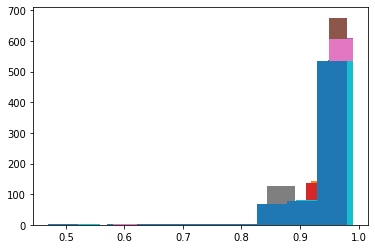

In [17]:
for i in range(0,11):
     n, bins, patches = plt.hist(out[:,i])
plt.show()

In [18]:
Detected_Barriers = out.copy()

for A in Detected_Barriers:
    for i in range(0,11):
        if A[i]>=Threshold[i]:
            A[i]=1
        else:
            A[i]=0
out[10], Detected_Barriers[10]

(array([0.99, 0.99, 0.99, 0.99, 0.97, 0.97, 0.98, 0.97, 0.98, 0.98, 0.96]),
 array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.]))

In [19]:
Tariff_keys = ['Direction', 'Distribution points', 'Import restraints', 'Purpose', 'Rates', 'Time length']
NonTariff_keys = ['Customs and entry \n procedures', 'Financial control', 'Government participation \n in trade', 'Product requirements', 'Quotas']
Tariff = {}
NonTariff = {}
for i in range(0,11):
    print(str(i),np.sum(Detected_Barriers[:,i]), int(round((np.sum(Detected_Barriers[:,i])/1164)*100,0)))
    if i < 6:
        Tariff[Tariff_keys[i]] = int(round((np.sum(Detected_Barriers[:,i])/1164)*100,0))
    else:
        NonTariff[NonTariff_keys[i-6]] = int(round((np.sum(Detected_Barriers[:,i])/1164)*100,0))


0 223.0 19
1 429.0 37
2 418.0 36
3 296.0 25
4 403.0 35
5 596.0 51
6 328.0 28
7 351.0 30
8 405.0 35
9 331.0 28
10 260.0 22


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


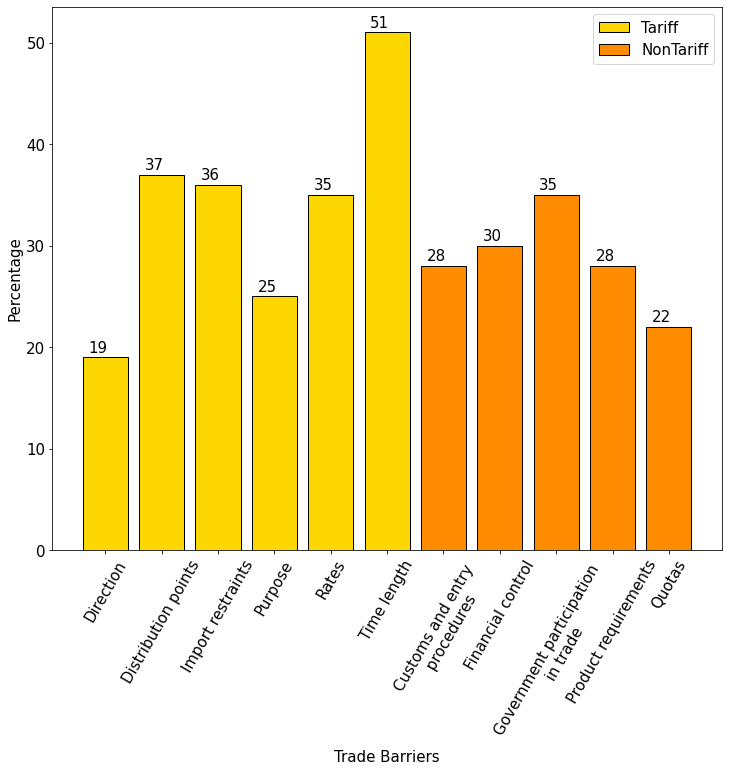

In [20]:
fig, ax = plt.subplots(figsize=(12,10))

Barrier_names = Tariff_keys + NonTariff_keys
Barrier_proportion = list(Tariff.values())+list(NonTariff.values())

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel("Trade Barriers",fontsize=15)
#ax.bar(Barrier_names, Barrier_proportion)

T = ax.bar(Tariff_keys, Tariff.values(), color = 'gold', edgecolor='black', label="Tariff")
NT = ax.bar(NonTariff_keys, NonTariff.values(), color = 'darkorange', edgecolor='black', label="NonTariff")

for index,data in enumerate(Barrier_proportion):
    ax.text(x=index-0.3 , y =data+0.5 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.xticks(rotation=60)

plt.legend(handles=[T, NT], prop={'size': 15})
fig.savefig('Finnish_Barriers.eps', format="eps", bbox_inches = 'tight')#, dpi=1000
plt.show()

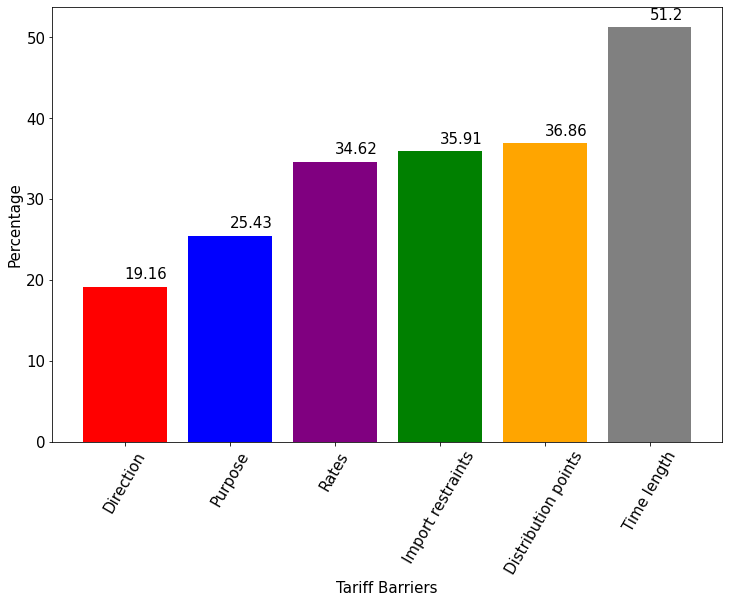

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
Sorted_Tariff = {k: v for k, v in sorted(Tariff.items(), key=lambda item: item[1])}
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel("Tariff Barriers",fontsize=15)
ax.bar(Sorted_Tariff.keys(), Sorted_Tariff.values(), color=['red', 'blue', 'purple', 'green', 'orange', 'gray'])
for index,data in enumerate(Sorted_Tariff.values()):
    ax.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.xticks(rotation=60)
fig.savefig('Finnish_Tariff_Barriers.eps', format="eps")

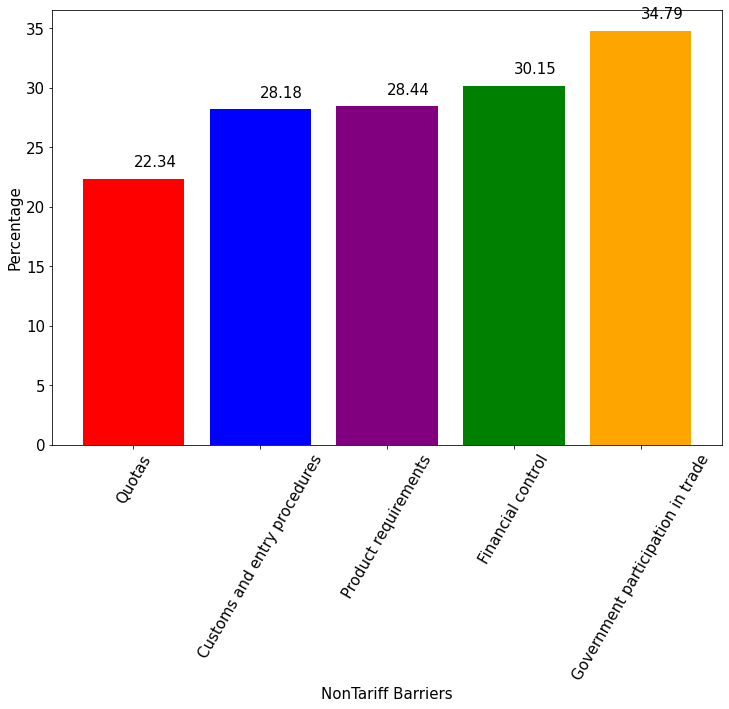

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
Sorted_NonTariff = {k: v for k, v in sorted(NonTariff.items(), key=lambda item: item[1])}
my_colors = 'rgbkymc'
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel("NonTariff Barriers",fontsize=15)
ax.bar(Sorted_NonTariff.keys(), Sorted_NonTariff.values(), color=['red', 'blue', 'purple', 'green', 'orange'])

for index,data in enumerate(Sorted_NonTariff.values()):
    ax.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.xticks(rotation=60)
fig.savefig('Finnish_NonTariff_Barriers.eps', format="eps")

In [21]:
Tariff_Text = dict.fromkeys(Tariff_keys , [])
NonTariff_Text = dict.fromkeys(NonTariff_keys , [])

for i in range(0,len(Texts)):
    for j in range(0,6):
        if Detected_Barriers[i][j] == 1.:
            Tariff_Text[Tariff_keys[j]].append(Texts[i])
    for j in range(0,5):
        if Detected_Barriers[i][j] == 1.:
            NonTariff_Text[NonTariff_keys[j]].append(Texts[i])

for j in range(0,6):
    Tariff_Text[Tariff_keys[j]] = list(set(Tariff_Text[Tariff_keys[j]]))
for j in range(0,5):
    NonTariff_Text[NonTariff_keys[j]] = list(set(NonTariff_Text[NonTariff_keys[j]]))

In [22]:
def Text_Clustering(List, N):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(List)

    vocab_inverted = {}
    for word, column_index in vectorizer.vocabulary_.items():
        vocab_inverted[column_index] = word

    clusterer = KMeans(n_clusters=N, init='k-means++', max_iter=1000, n_init=1)
    clustered_docs = clusterer.fit(X)
    
    Text_Centers = []
    for i, center in enumerate(clusterer.cluster_centers_):
        center_index = [(x, i) for i, x in enumerate(center)]
        topn = sorted(center_index, reverse=True)[:7]
        Text_Centers.append(' '.join([vocab_inverted[i] for _, i in topn]))
    return Text_Centers

In [23]:
Tariff_Cluster = dict.fromkeys(Tariff_keys , [])
NonTariff_Cluster = dict.fromkeys(NonTariff_keys , [])

for j in range(0,6):
    Tariff_Cluster[Tariff_keys[j]] = Text_Clustering(Tariff_Text[Tariff_keys[j]], 7)
    
for j in range(0,5):
    NonTariff_Cluster[NonTariff_keys[j]] = Text_Clustering(NonTariff_Text[NonTariff_keys[j]], 7)

In [24]:
for key in Tariff_Cluster.keys():
    print('_________________'+key+'_________________')
    for text in Tariff_Cluster[key]:
        print(text)

_________________Direction_________________
frozen tuna teppo russian morning box steaks
salmon sold wild fish finnish pangasius store
salt fish taste dry salmon pepper matter
important smoking fridge result end time christmas
http fi www html reseptit uutiset bream
fish make know don works try pike
com https salmonprice report public nasdaqomxtrader salmon
_________________Distribution points_________________
salmon com tuna bream https salmonprice report
sold salmon caught store little market net
salt work pepper black salmon lemon offered
fi http www html uutiset yle reseptit
fish sugar dry thing long yes spice
fish smoke important taste pay pike catch
lines teppo roar kyrsä kossu keppana kent
_________________Import restraints_________________
tuna use russian know don really frozen
norway used cargo exports crabs real_estate job_in_fishing_industry
works taste smoked try fish salmon dry
fi http www trout rainbow html uutiset
bream make place bark try fish oven
salmon com salmonpri

In [25]:
for key in NonTariff_Cluster.keys():
    print('_________________'+key+'_________________')
    for text in NonTariff_Cluster[key]:
        print(text)

_________________Customs and entry 
 procedures_________________
russian frozen offered tuna fresh possible vendace
salmon https salmonprice report public nasdaqomxtrader com
com http aijaa 5rrbqq specific_preparation_and_professional cooking real_estate
fish make pike smoke thing try pay
smoking result proper end important hours course
fi http www uutiset reseptit yle herring
use products shell allergy plastic zero theory
_________________Financial control_________________
salmon salmonprice report public nasdaqomxtrader https norwegian
fish new pay pike important work pangasius
http fi www com herring html uutiset
smoke taste trout rainbow products big allergy
perch rooster different vendace pike spawn search
smoking smoked oven ka dry proper cucumber
russian frozen offered tuna fresh possible vendace
_________________Government participation 
 in trade_________________
fi http www html uutiset rainbow herring
fish pay work spicy new pocero night
pangasius common official trade speci

### Text Generation GPT-2

In [12]:
Fi = '''bream frozen tuna works Russian know really fish salt oven leather pay recipe peppersalmon Norwegian salmon price report public fridge result time different quite perch Christmas thing fish course old smoke pocero recently
        fish works thing Russian important lines vendace fish pike salmon Norwegian eaten healthy pangasiussold smoke company store used 90 spice know don rooster bag using plastic really salmon oven make salt tuna let soup
        bundle medallions butterflies visual pants illusions sleep fish use pay smoke important products thought herring really bream fi end fineli food salmon salmon price report public sold Russian course frozen tuna steaks yes
        fish pay spicy smoke pieces comes beat pike perch eaten rooster different frozen offered spice time got fish sugar sold smokingsalmon salmon price report public works try browser dry blaze potato bream
        frozen possible herring important use Christmas rooster fish taste make pay smoke today workspice sugar fish broth pieces small 10 rainbow trout taste oven salt fillets potato boneless shrimp came
        fish works try tuna bream make important Russia herring thing really Christmas don know talk hardly ethics salmon Norwegian salmon price report public smoke know situation trade spice using don
        fence different fish case line pond company thing main matter possible pipe option happened video write work need throw maybe pos know work try topic fish forum people work pond winter fish source ponds hectares
        work time line source meters day pump matter fish possible genel organic come source know work maybe video look fish kind option principle tell tank ozone work ice thing main pond fish money launch super
        pipe thing matter line pond organization company fish main thing source work pond quotation fence understand land different time terms composition work day long video maybe rest time option pump case possible make work little
        matter time option company fish principle line thing pond main fish pipe winter looksource quotation work fish season meters reservoir fence crucian let signal bonuaid waiting float work compreor fish video day rest try
        line fence fish case company pipe option look life work uninterruptible thousands tens supplies work fish pond winter ponds hectares small thing main matter pctice fact dam different source quotation work reservoir organic fish pond
     '''

Ru = '''thing table line office field position time work meters day maybe video rest 30 pond matter air organic thing 38 fact possible trade thing tell line fence case fish source main thing work quotation reservoir
        understand time matter write fish region eat thing main launch super dam source attached work day years rest need maybe look fish pond source work fence meters quotation pipe principle option air according different siphon
        pond fish matter winter year thing let according rest work technology profile time thing thing main source line case right option need rubles meters work 100 20 prices work video day maybe source fish know
        work fish video line source make fence need money work case excavator soil winter 30 action power kind loading liters work time work pump long come thing compreor thing pond main fish crucian meters winter
        thing main fish fence case company option work rest try fish waiting maybe pump matter need day oxygen work organic fact pond hectares reservoir fish field meters ponds source quotation work video line ejector air
        thing right main away depth line pond thing fence company case main line time work ejector day source pump long rest meters winter work rubles pond excavator soil fish matter understand pond video organic thing
        fence time compreor battery power company matter organic air fish 38 really small work rest pump source try lot fish meters write fish case 100 line work thing pond main fish winter look work
        line option company fence matter principle time thing main fish different fishing understand check ejector 10m venturi injector video work pond work fish money meters possible need work video source pump rest maybe try
        thing main line option fence organization live work day source rest pump long level fish matter understand video thing fact different pond case possible meters compreor fish pipe make hole fence source mink believe batteries
        option line principle company fence case crucian right need matter pond little work use thing main fish time pond ponds fishing meters winter work excavator rubles pond soil work video maybe try day source fish
        try company pump fact option tell different time used work terms 50 situation thing main meters matter fence pond option fish pond work fishing ponds hectares pctice work source quotation winter year think day
     '''

In [13]:
def Masked_WordCloud(Text, Max_Words,Maskfile, Maskedfile):
    mask = np.array(Image.open('Masks/'+Maskfile+'.png'))
    image_colors = ImageColorGenerator(mask)

    wc = WordCloud(stopwords=STOPWORDS, 
               mask=mask, background_color="white",
               max_words=Max_Words, max_font_size=256,
               random_state=42, width=mask.shape[1],
               contour_width=5, contour_color='steelblue', 
               height=mask.shape[0])

    wc.generate(Text)
    plt.figure(figsize=[15,9])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis('off')

    plt.savefig(Maskedfile+'.eps', format="eps")

    plt.show()

In [28]:
Text = Fi  
Text = Text.lower()

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue',width=900, height=600)
# Generate a word cloud
wordcloud.generate(Text)
# Visualize the word cloud

plt.figure(figsize=[15,9])
wordcloud.to_image()
wordcloud.to_file('Clusters_Finland.eps')

<Figure size 1080x648 with 0 Axes>

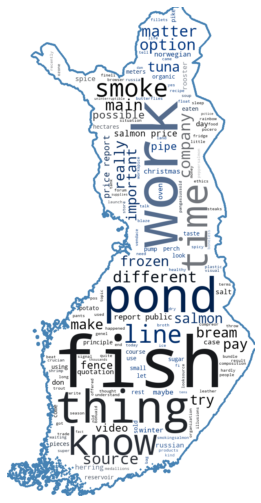

In [19]:
Text = Fi

Text = re.sub('[,\.!?]', '', Text)    
Text = Text.lower()

Masked_WordCloud(Text, 10000,'Flag-map_of_Finland', 'Clusters_Finland')
#Masked_WordCloud(Text, 10000,'Russia', 'Masked_Russia')

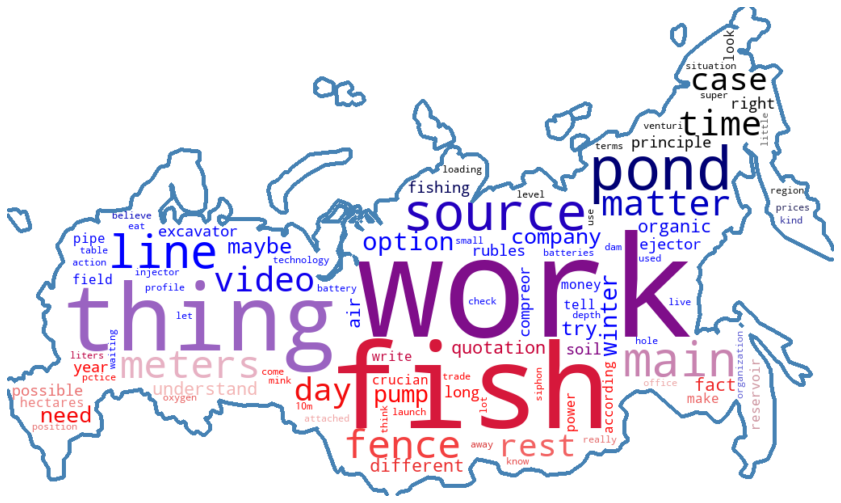

In [20]:
Text = Ru

Text = re.sub('[,\.!?]', '', Text)    
Text = Text.lower()

Masked_WordCloud(Text, 10000,'Russia', 'Clusters_Russia')

In [29]:
Text = Ru  
Text = Text.lower()

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue',width=900, height=600)
# Generate a word cloud
wordcloud.generate(Text)
# Visualize the word cloud

plt.figure(figsize=[15,9])
wordcloud.to_image()
wordcloud.to_file('Clusters_Russia.eps')

<Figure size 1080x648 with 0 Axes>